In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cpu


In [13]:
# Load data
df = pd.read_csv('../data/final_df.csv')

# Convert datetime
df['created_at'] = pd.to_datetime(df['created_at'])

print(f"Dataset size: {len(df):,} comments")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nPercentages:")
print(df['sentiment_label'].value_counts(normalize=True) * 100)

# Use the BERT-cleaned text (minimal preprocessing)
texts = df['text_bert'].values
labels = df['sentiment_label'].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

print(f"\nLabel mapping:")
for idx, label in enumerate(le.classes_):
    print(f"  {idx}: {label}")

Dataset size: 2,985 comments

Sentiment distribution:
sentiment_label
positive    1991
negative     906
neutral       88
Name: count, dtype: int64

Percentages:
sentiment_label
positive    66.700168
negative    30.351759
neutral      2.948074
Name: proportion, dtype: float64

Label mapping:
  0: negative
  1: neutral
  2: positive


In [14]:
# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, encoded_labels,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=encoded_labels
)

# Second split: separate validation from training (15/85 ≈ 0.176 of temp = 15% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 15% of total dataset (0.15 / 0.85 ≈ 0.176)
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print(f"Training set: {len(X_train):,} ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test set: {len(X_test):,} ({len(X_test)/len(texts)*100:.1f}%)")

print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.classes_[cls]}: {count} ({count/len(y_train)*100:.1f}%)")

Training set: 2,090 (70.0%)
Validation set: 447 (15.0%)
Test set: 448 (15.0%)

Class distribution in training set:
  negative: 634 (30.3%)
  neutral: 62 (3.0%)
  positive: 1394 (66.7%)


In [15]:
# Load pre-trained BERT tokenizer
MODEL_NAME = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Loaded tokenizer: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")

# Test tokenization
sample_text = X_train[0]
print(f"\nSample text: {sample_text[:100]}...")
encoded = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
print(f"Tokenized length: {encoded['input_ids'].shape}")
print(f"First 10 tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0][:10])}")


Loaded tokenizer: distilbert-base-cased
Vocabulary size: 28,996

Sample text: Isn’t being able to feel the root of all evil. It’s also the root of joy, but I don’t really need AI...
Tokenized length: torch.Size([1, 128])
First 10 tokens: ['[CLS]', 'Isn', '’', 't', 'being', 'able', 'to', 'feel', 'the', 'root']


### Create Custom Dataset Class

In [16]:
class SentimentDataset(Dataset):
    """Custom Dataset for BERT sentiment analysis"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
MAX_LENGTH = 128  # Maximum sequence length (adjust based on your data)

train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, MAX_LENGTH)

print(f"✓ Created datasets:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

✓ Created datasets:
  Training: 2090 samples
  Validation: 447 samples
  Test: 448 samples


### Create Dataloaders

In [17]:
BATCH_SIZE = 16  # Adjust based on your GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for Windows, 2-4 for Linux/Mac
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"✓ Created DataLoaders:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Created DataLoaders:
  Batch size: 16
  Training batches: 131
  Validation batches: 28
  Test batches: 28


### Initialize BERT

In [18]:
# Load pre-trained BERT model for sequence classification
num_classes = len(le.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device (GPU/CPU)
model = model.to(device)

print(f"✓ Loaded BERT model: {MODEL_NAME}")
print(f"✓ Number of classes: {num_classes}")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded BERT model: distilbert-base-cased
✓ Number of classes: 3
✓ Model parameters: 65,783,811
✓ Trainable parameters: 65,783,811


In [20]:
# Training hyperparameters
EPOCHS = 3  # Start with 3 epochs (BERT converges quickly)
LEARNING_RATE = 2e-5  # Standard BERT learning rate

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights for imbalanced data:")
for idx, weight in enumerate(class_weights):
    print(f"  {le.classes_[idx]}: {weight:.3f}")

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"\n✓ Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total training steps: {total_steps}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: Linear with warmup")

Class weights for imbalanced data:
  negative: 1.099
  neutral: 11.237
  positive: 0.500

✓ Training configuration:
  Epochs: 3
  Learning rate: 2e-05
  Total training steps: 393
  Optimizer: AdamW
  Scheduler: Linear with warmup


### Training and Evaluation

In [21]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    """Train model for one epoch"""
    model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Predictions
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': loss.item(), 'acc': (correct_predictions.double() / total_samples).item()})
    
    return correct_predictions.double() / total_samples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    """Evaluate model"""
    model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return correct_predictions.double() / total_samples, np.mean(losses), all_preds, all_labels

print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


In [22]:
# Training history
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_val_acc = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_acc, train_loss = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler
    )
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    # Validate
    val_acc, val_loss, _, _ = eval_model(model, val_loader, loss_fn, device)
    
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save history
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print(f"✓ Saved best model with validation accuracy: {val_acc:.4f}")

print("TRAINING COMPLETE")
print(f"Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.6778 | Train Acc: 0.6957


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5647 | Val Acc: 0.7606
✓ Saved best model with validation accuracy: 0.7606

Epoch 2/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.4585 | Train Acc: 0.8321


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5644 | Val Acc: 0.7718
✓ Saved best model with validation accuracy: 0.7718

Epoch 3/3
--------------------------------------------------------------------------------


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Train Loss: 0.3178 | Train Acc: 0.8957


Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6415 | Val Acc: 0.7696
TRAINING COMPLETE
Best validation accuracy: 0.7718


### Plot training history

✓ Saved: bert_training_history.png


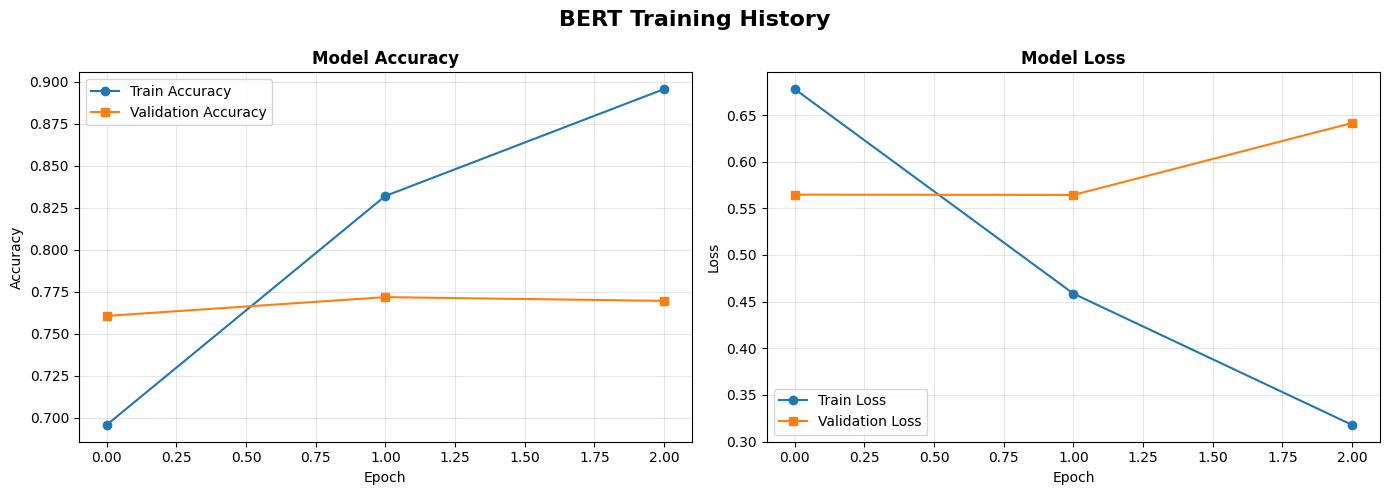

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('BERT Training History', fontsize=16, fontweight='bold')

# Plot accuracy
ax = axes[0]
ax.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax.plot(history['val_acc'], label='Validation Accuracy', marker='s')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot loss
ax = axes[1]
ax.plot(history['train_loss'], label='Train Loss', marker='o')
ax.plot(history['val_loss'], label='Validation Loss', marker='s')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bert_training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved: bert_training_history.png")
plt.show()

### Evaluation on Test Set

In [24]:
# Load best model
model.load_state_dict(torch.load('best_bert_model.pt'))
model.eval()

# Evaluate
test_acc, test_loss, test_preds, test_labels = eval_model(
    model, test_loader, loss_fn, device
)

print(f"\n✓ Test Accuracy: {test_acc:.4f}")
print(f"✓ Test Loss: {test_loss:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\n📈 Confusion Matrix:")
print(cm)

# Calculate per-class metrics
print("\n📊 Per-Class Metrics:")
for idx, class_name in enumerate(le.classes_):
    class_mask = np.array(test_labels) == idx
    class_acc = accuracy_score(
        np.array(test_labels)[class_mask],
        np.array(test_preds)[class_mask]
    )
    print(f"  {class_name}: {class_acc:.4f}")

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]


✓ Test Accuracy: 0.7522
✓ Test Loss: 0.6018

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.74      0.66       136
     neutral       0.00      0.00      0.00        13
    positive       0.84      0.79      0.82       299

    accuracy                           0.75       448
   macro avg       0.48      0.51      0.49       448
weighted avg       0.74      0.75      0.75       448


📈 Confusion Matrix:
[[100   0  36]
 [  5   0   8]
 [ 62   0 237]]

📊 Per-Class Metrics:
  negative: 0.7353
  neutral: 0.0000
  positive: 0.7926


### Visualization


✓ Saved: bert_evaluation.png


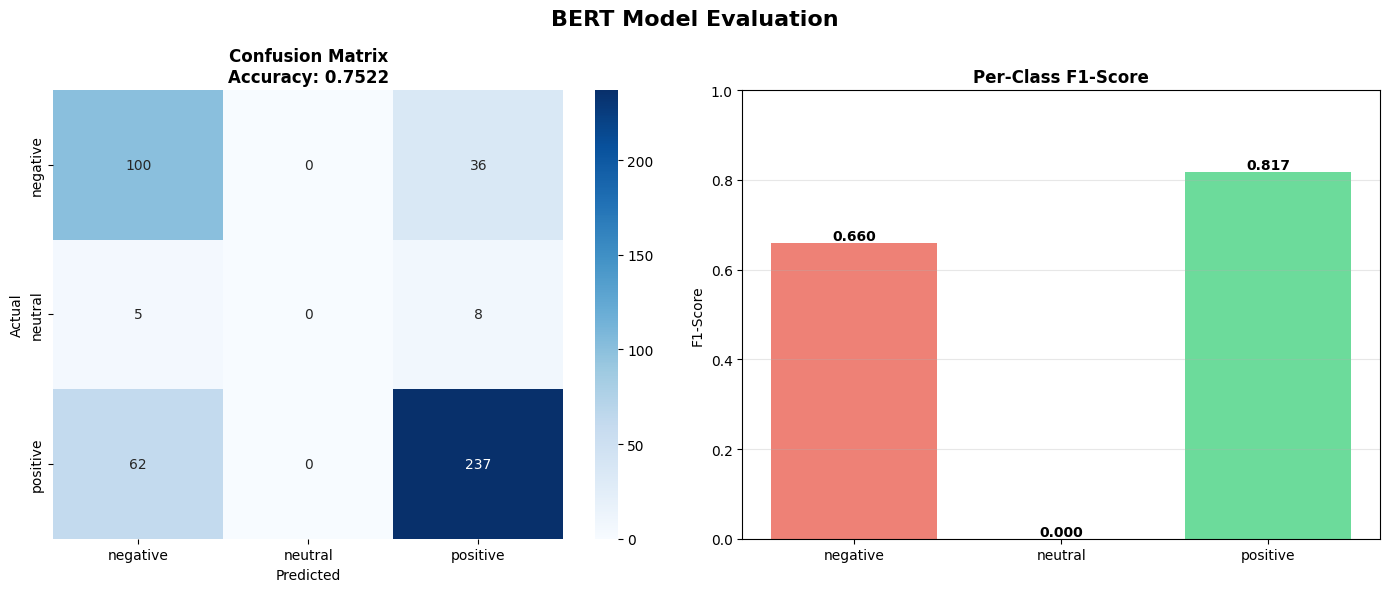

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('BERT Model Evaluation', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=ax)
ax.set_title(f'Confusion Matrix\nAccuracy: {test_acc:.4f}', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# 2. Per-Class F1 Scores
ax = axes[1]
from sklearn.metrics import f1_score
f1_scores = f1_score(test_labels, test_preds, average=None)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
bars = ax.bar(le.classes_, f1_scores, color=colors, alpha=0.7)
ax.set_title('Per-Class F1-Score', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('bert_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: bert_evaluation.png")
plt.show()


### Inference Function for New data

In [26]:
def predict_sentiment(text, model, tokenizer, device, label_encoder, max_length=128):
    """Predict sentiment for new text"""
    model.eval()
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        _, prediction = torch.max(logits, dim=1)
    
    predicted_class = label_encoder.inverse_transform(prediction.cpu().numpy())[0]
    confidence = probs[0][prediction].item()
    
    # Get all class probabilities
    all_probs = {
        label_encoder.classes_[i]: probs[0][i].item()
        for i in range(len(label_encoder.classes_))
    }
    
    return predicted_class, confidence, all_probs

# Test the function
print("\n" + "="*80)
print("TESTING INFERENCE")
print("="*80)

test_texts = [
    "AI is going to revolutionize healthcare and save millions of lives!",
    "I'm worried about job losses due to artificial intelligence automation",
    "Machine learning models can be biased and unfair"
]

for text in test_texts:
    sentiment, confidence, probs = predict_sentiment(text, model, tokenizer, device, le)
    print(f"\nText: {text}")
    print(f"Predicted: {sentiment} (confidence: {confidence:.3f})")
    print(f"All probabilities: {probs}")


TESTING INFERENCE

Text: AI is going to revolutionize healthcare and save millions of lives!
Predicted: positive (confidence: 0.918)
All probabilities: {'negative': 0.05405670776963234, 'neutral': 0.027802053838968277, 'positive': 0.9181411862373352}

Text: I'm worried about job losses due to artificial intelligence automation
Predicted: negative (confidence: 0.876)
All probabilities: {'negative': 0.8762016892433167, 'neutral': 0.03158050775527954, 'positive': 0.09221786260604858}

Text: Machine learning models can be biased and unfair
Predicted: negative (confidence: 0.604)
All probabilities: {'negative': 0.6043245792388916, 'neutral': 0.10814783722162247, 'positive': 0.2875276505947113}
